# TLKM Stock Prediction Using Wavelet-GRU

* **Wavelet Transform** is a signal analysis technique used to break down data into different frequency components and time scales. In the context of stock price prediction, Wavelet helps decompose stock price data into multiple scales or frequency components, effectively reducing noise in stock prices and capturing seasonal patterns.  

* **Gated Recurrent Unit (GRU)** is a type of Recurrent Neural Network (RNN) designed to address the vanishing gradient problem and improve efficiency in processing sequential data. GRU consists of two main gates that control the flow of information: the **Update Gate** and the **Reset Gate**, allowing it to capture long-term patterns in price trends.  

By combining these two methods, the prediction results become more accurate, stable, and computationally efficient.



In [ ]:
!pip install PyWavelets

In [ ]:
import numpy as np
import pandas as pd
import pywt
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU

In [ ]:
df = pd.read_csv('TLKM.csv')
df.head()

,date,previous,open_price,first_trade,high,low,close,change,volume,value,...,bid_volume,listed_shares,tradeble_shares,weight_for_index,foreign_sell,foreign_buy,delisting_date,non_regular_volume,non_regular_value,non_regular_frequency
0,2019-07-29,4160.0,4150.0,4160.0,4240.0,4140.0,4200.0,40.0,54336900.0,2.275912e+11,...,4598200.0,9.906222e+10,9.906222e+10,9.906222e+10,43832400.0,21574700.0,NaN,3415316.0,1.422425e+10,29.0
1,2019-07-30,4200.0,4280.0,4290.0,4300.0,4260.0,4270.0,70.0,88417200.0,3.781763e+11,...,2875700.0,9.906222e+10,9.906222e+10,9.906222e+10,34092300.0,41518800.0,NaN,13680111.0,5.808870e+10,17.0
2,2019-07-31,4270.0,4240.0,4240.0,4300.0,4210.0,4300.0,30.0,175741000.0,7.529697e+11,...,381100.0,9.906222e+10,9.906222e+10,9.906222e+10,94878800.0,111804000.0,NaN,10329255.0,4.363287e+10,20.0
3,2019-08-01,4300.0,4300.0,4300.0,4300.0,4260.0,4280.0,-20.0,94856600.0,4.056602e+11,...,1029500.0,9.906222e+10,9.906222e+10,9.906222e+10,52182600.0,66558500.0,NaN,14709129.0,6.308473e+10,35.0
4,2019-08-02,4280.0,4280.0,4280.0,4300.0,4250.0,4280.0,0.0,82253800.0,3.517415e+11,...,3122200.0,9.906222e+10,9.906222e+10,9.906222e+10,39395300.0,59903100.0,NaN,17645000.0,7.542574e+10,44.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355 entries, 0 to 1354
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1355 non-null   object 
 1   previous               1355 non-null   float64
 2   open_price             1355 non-null   float64
 3   first_trade            1355 non-null   float64
 4   high                   1355 non-null   float64
 5   low                    1355 non-null   float64
 6   close                  1355 non-null   float64
 7   change                 1355 non-null   float64
 8   volume                 1355 non-null   float64
 9   value                  1355 non-null   float64
 10  frequency              1355 non-null   float64
 11  index_individual       1355 non-null   float64
 12  offer                  1355 non-null   float64
 13  offer_volume           1355 non-null   float64
 14  bid                    1355 non-null   float64
 15  bid_

The columns used for stock prediction are **Date** and **Close**, as they are the primary factors in analyzing stock price movements.  

* **Date** is used as the time axis (time series), allowing for the analysis of historical stock price trends.  
* **Close** represents the stock's closing price for each trading day, reflecting the balance between supply and demand in the market at the end of the trading session.

## Data Preprocessing

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

df = df[['date', 'close']].sort_values(by='date')

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

## Wavelet Transform

In [ ]:
def wavelet_transform(data, wavelet='db4', level=1):
    coeffs = pywt.wavedec(data, wavelet, level=level) # wavelet decomposition
    coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]] # remove noise
    reconstructed_data = pywt.waverec(coeffs, wavelet) # data reconstruction
    reconstructed_data = reconstructed_data[:len(data)] # adjust data length
    return reconstructed_data

In [ ]:
wavelet_data = wavelet_transform(scaled_data.flatten(), wavelet='db4', level=1).reshape(-1, 1)

In [ ]:
print("Length scaled_data:", len(scaled_data))
print("Length wavelet_data:", len(wavelet_data))

Length scaled_data: 1355
Length wavelet_data: 1355


## Dataset Creation

In [ ]:
train_ratio = 0.8
time_step = 60

In [ ]:
# Splitting Standard Dataset
train_size_std = int(len(scaled_data) * train_ratio)
train_data_std = scaled_data[:train_size_std]
test_data_std  = scaled_data[train_size_std:]

In [ ]:
# Splitting Wavelet Dataset
train_size_wav = int(len(wavelet_data) * train_ratio)
train_data_wav = wavelet_data[:train_size_wav]
test_data_wav  = wavelet_data[train_size_wav:]

In [ ]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [ ]:
# Standard Dataset Creation
X_train_std, y_train_std = create_dataset(train_data_std, time_step)
X_test_std, y_test_std   = create_dataset(test_data_std, time_step)

In [ ]:
# Wavelet Dataset Creation
X_train_wav, y_train_wav = create_dataset(train_data_wav, time_step)
X_test_wav, y_test_wav   = create_dataset(test_data_wav, time_step)

In [ ]:
# Reshape to (samples, time_step, feature) format - a 3D shape that can be processed by GRU
X_train_std = X_train_std.reshape(X_train_std.shape[0], X_train_std.shape[1], 1)
X_test_std  = X_test_std.reshape(X_test_std.shape[0], X_test_std.shape[1], 1)

X_train_wav = X_train_wav.reshape(X_train_wav.shape[0], X_train_wav.shape[1], 1)
X_test_wav  = X_test_wav.reshape(X_test_wav.shape[0], X_test_wav.shape[1], 1)

In [ ]:
print("Shape X_train_wav:", X_train_wav.shape)
print("Shape X_test_wav:", X_test_wav.shape)
print("Shape X_train_std:", X_train_std.shape)
print("Shape X_test_std:", X_test_std.shape)

Shape X_train_wav: (1024, 60, 1)
Shape X_test_wav: (211, 60, 1)
Shape X_train_std: (1024, 60, 1)
Shape X_test_std: (211, 60, 1)


## Wavelet-GRU

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, scaler):
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    y_pred = model.predict(X_test)

    y_pred = scaler.inverse_transform(y_pred)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    mae = mean_absolute_error(y_test_actual, y_pred)
    mse = mean_squared_error(y_test_actual, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

    print(f"\nEvaluation Model of Wavelet-GRU:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%\n")

    return {
        "y_pred": y_pred,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape
    }

In [ ]:
def build_wavelet_gru(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
model_wavelet = build_wavelet_gru((time_step, 1))
results = evaluate_model(model_wavelet, X_train_wav, y_train_wav, X_test_wav, y_test_wav, scaler)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1514
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0056
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0036
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0014
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.9387e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.9712e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.6444e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.4100e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.5769e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.5287e-04
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 7.6796e-04
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.7751e-04
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.1082e-04
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms

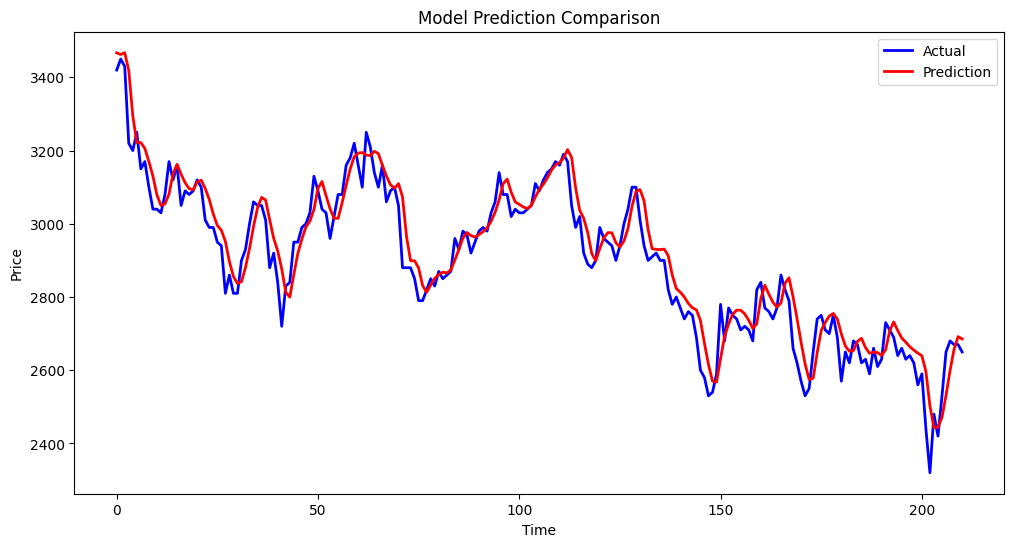

In [ ]:
y_test_actual = scaler.inverse_transform(y_test_std.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual', color='blue', linewidth=2)
plt.plot(results["y_pred"], label='Prediction', color='red', linewidth=2)
plt.legend()
plt.title("Model Prediction Comparison")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [ ]:
print("Evaluation Metrics of Wavelet-GRU model:")
for metric, value in results.items():
    if metric != "y_pred":
        print(f"{metric}: {value:.4f}")

Evaluation Metrics of Wavelet-GRU model:
MAE: 44.9405
MSE: 3243.1011
RMSE: 56.9482
MAPE: 1.5829


## Calculation of Value at Risk (VaR) and Expected Shortfall (ES)

In [ ]:
def calculate_var_es(returns, confidence_level=0.95):
    var = np.percentile(returns, (1 - confidence_level) * 100)
    es = np.mean(returns[returns < var])
    return var, es

In [ ]:
actual_returns = np.diff(y_test_actual.flatten()) / y_test_actual[:-1].flatten()

In [ ]:
y_pred = model_wavelet.predict(X_test_wav)
y_pred = scaler.inverse_transform(y_pred)
model_predictions = y_pred.flatten()

predicted_returns = np.diff(model_predictions) / model_predictions[:-1]
print(predicted_returns)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[-1.31312246e-03  1.39318430e-03 -1.38637368e-02 -3.62404622e-02
 -2.23372318e-02  3.36455232e-05 -4.96398704e-03 -1.12153804e-02
 -1.24706673e-02 -1.63807180e-02 -9.44805983e-03  1.40863413e-03
  8.78738239e-03  1.80008132e-02  8.24585650e-03 -8.46150517e-03
 -7.46815745e-03 -5.23780938e-03 -1.02986244e-03  7.00002257e-03
  1.53924269e-03 -7.30619254e-03 -9.74256452e-03 -1.30210696e-02
 -1.02149835e-02 -4.35478985e-03 -1.01980614e-02 -1.87197309e-02
 -1.40986377e-02 -6.62755081e-03  1.74435996e-03  1.36252688e-02
  1.80422645e-02  2.06784550e-02  1.70182046e-02  9.13577620e-03
 -2.25883676e-03 -1.76493041e-02 -1.68195590e-02 -1.16324276e-02
 -1.67965610e-02 -2.22051889e-02 -4.64380439e-03  2.18599718e-02
  2.03779805e-02  1.32814487e-02  1.12110907e-02  5.43770287e-03
  1.04663931e-02  1.90081913e-02  6.09504525e-03 -1.24220783e-02
 -1.16722863e-02 -8.50693136e-03 -1.36031129e-04  1.42072253e-02
  1.54033834e-02  1.44556221e-02  1.06476350e-02  3.

In [ ]:
# Calculate VaR and ES for actual returns
def calculate_var_es(returns, confidence_level=0.95):
    var = np.percentile(returns, (1 - confidence_level) * 100)
    es = np.mean(returns[returns < var])
    return var, es

In [ ]:
# For example, the initial investment is one million
initial_investment = 1000000

In [ ]:
var_actual, es_actual = calculate_var_es(actual_returns, confidence_level=0.95)
var_absolute_actual = initial_investment * abs(var_actual)
es_absolute_actual = initial_investment * abs(es_actual)

print("=== Actual Risk Analysis Results ===")
print(f"VaR Actual (95% Confidence): {var_actual:.4f}")
print(f"ES Actual (95% Confidence): {es_actual:.4f}")
print(f"VaR Absolut Actual: {var_absolute_actual:.2f}")
print(f"ES Absolut Actual: {es_absolute_actual:.2f}")

=== Actual Risk Analysis Results ===
VaR Actual (95% Confidence): -0.0354
ES Actual (95% Confidence): -0.0472
VaR Absolut Actual: 35448.73
ES Absolut Actual: 47158.99


In [ ]:
# Calculate VaR and ES for prediction returns
var_pred, es_pred = calculate_var_es(predicted_returns, confidence_level=0.95)
var_absolute_pred = initial_investment * abs(var_pred)
es_absolute_pred = initial_investment * abs(es_pred)

print(f"Wavelet-GRU - VaR (95% Confidence): {var_pred:.4f}")
print(f"Wavelet-GRU - ES (95% Confidence): {es_pred:.4f}")
print(f"Wavelet-GRU - VaR Absolut: {var_absolute_pred:.2f}")
print(f"Wavelet-GRU - ES Absolut: {es_absolute_pred:.2f}")

Wavelet-GRU - VaR (95% Confidence): -0.0222
Wavelet-GRU - ES (95% Confidence): -0.0269
Wavelet-GRU - VaR Absolut: 22151.52
Wavelet-GRU - ES Absolut: 26943.25


## Prediction

In [ ]:
future_days = 250

def forecast_with_model(model, X_input, future_days):
    forecast = []
    X_temp = X_input.copy()

    for _ in range(future_days):
        prediction = model.predict(X_temp)
        forecast.append(prediction[0, 0])
        X_temp = np.append(X_temp[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)
    return forecast

In [ ]:
X_input_last = X_test_wav[-1].reshape(1, time_step, 1)
forecast = forecast_with_model(model_wavelet, X_input_last, future_days)
forecast = np.array(forecast).reshape(-1, 1)
forecast_inversed = scaler.inverse_transform(forecast)
model_forecasts = forecast_inversed.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

In [ ]:
future_dates = pd.date_range(start=df['date'].values[-1], periods=future_days, freq='D')
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Prediction': model_forecasts.flatten()
})

print("\n=== Prediction Results (Day) ===")
forecast_df.head()


=== Prediction Results (Day) ===


,Date,Prediction
0,2025-02-21,2685.386719
1,2025-02-22,2698.398438
2,2025-02-23,2711.363281
3,2025-02-24,2724.308838
4,2025-02-25,2737.194092


In [ ]:
monthly_forecasts = {}
monthly_forecasts = forecast_df.set_index('Date').resample('M').first().reset_index()

<ipython-input-127-eef51cde7728>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_forecasts = forecast_df.set_index('Date').resample('M').first().reset_index()


In [ ]:
forecast_dfm = monthly_forecasts[list(monthly_forecasts.keys())[0]]
forecast_dfm = pd.merge(forecast_dfm, monthly_forecasts, on='Date', how='outer', suffixes=('_old', '_new'))

print("=== Prediction Result (Month) ===")
print(forecast_dfm)

=== Prediction Result (Month) ===
        Date   Prediction
0 2025-02-28  2685.386719
1 2025-03-31  2787.879150
2 2025-04-30  3132.560547
3 2025-05-31  3407.426514
4 2025-06-30  3652.400391
5 2025-07-31  3860.448975
6 2025-08-31  4046.327393
7 2025-09-30  4197.485352
8 2025-10-31  4305.313477


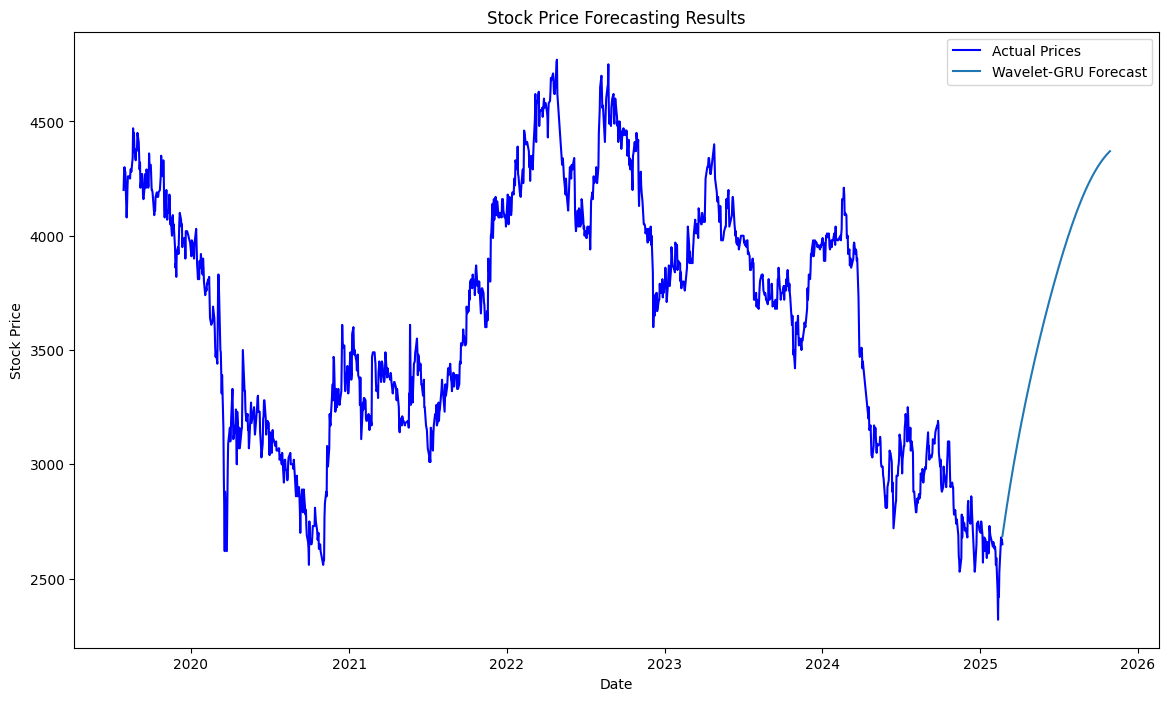

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(df['date'], df['close'], color='blue', label='Actual Prices')
future_dates = pd.date_range(start=df['date'].values[-1], periods=future_days, freq='D')
plt.plot(future_dates, model_forecasts, label=f'Wavelet-GRU Forecast')
plt.title('Stock Price Forecasting Results')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()